# Minería de reglas de asociación espacial sobre Minecraft

## El Proyecto
Este proyecto tiene como objetivo la aplicación de algoritmos de Inteligencia Artificial. La idea inicial consistió en buscar una solución a un problema particular que se puede explicar de la siguiente manera:

Dentro de la industria de creación de videojuegos existe un area grande e importante que consiste en la generación procedural.
Se le llama generación procedural de contenido, o **PCG** (*Procedural Content Generation*) por sus siglas en ingles, a la creación algorítmica de contenido para videojuegos con entradas del usuario limitadas o indirectas. [*Procedural Content
Generation in Games_ Noor Shaker,Julian Togelius,Mark J. Nelson*].  

Dentro de este area existen varios algoritmos que permiten la generación de contenido a partir de el establecimiento de parámetros de entrada que permiten al Diseñador orientar el funcionamiento del algoritmo. Teniendo en cuenta esta característica surge la pregunta: 
- ¿Sería posible mediante un algoritmo de inteligencia artificial y un entorno no generado artificialmente, poder *inferir* parámetros para que el algoritmo genere entornos similares?  

O de otra manera:
- ¿Puedo ***inferir las relaciones*** que existen entre los objetos de un entorno dado y, a partir de ellos, establecer parámetros para un algoritmo de generación procedural?

Debido a la extension que conllevaría realizar un proyecto para contestar estas preguntas, se decidió que el enfoque del proyecto estará en la búsqueda y comparación de algoritmos de inteligencia artificial que permitan la descripción, aprendizaje o inferencia de las relaciones que existen entre objetos en un espacio físico o virtual.

Con la exploración bibliográfica se puede entender que existe un area de investigación dentro de la ciencia en minería de datos que enfocada en como realizar las tareas de minería de datos sobre bases de datos espaciales o geográficas. La **Minería de Datos Espaciales** o **SDM** es un proceso de descubrimiento y extracción de conocimiento generalizado sobre gran cantidad de datos espaciales. [Spatial Data Mining_ Theory and Application_Deren L., Shuliang W., Deyi L]

El proyecto entonces consistirá en la aplicación de algunas técnicas y algoritmos utilizados en el area de *SDM* para realizar la inferencia de relaciones entre objetos espaciales en un entorno. Concretamente, los aplicaremos sobre un conjunto de datos extraídos del Videojuego *Minecraft*.

*Minecraft* es un videojuego 3D que utiliza un complejo procedimiento de generación procedural para la creación de terrenos de juego utilizando bloques. Se toma este escenario para la realización del proyecto debido a que los datos correspondientes a un terreno generado en el videojuego son de fácil acceso y la extracción de es sencilla, además, la disposición de los objetos dentro del juego son bloques con coordenadas rectangulares. Se puede obtener mas información sobre el procedimiento de generación procedural en está pagina web: [The World Generation of Minecraft](https://www.alanzucconi.com/2022/06/05/minecraft-world-generation/).

In [ ]:
#Imports

import apriori
import preprocess
import ploting

## Obtención de los datos del Videojuego
Para extraer la información sobre los bloques de Minecraft utilizare la información brindada por esta pagina web:[Minecraft Region file format](https://minecraft.fandom.com/wiki/Region_file_format). 

En la capeta de instalación del videojuego encontramos una carpeta donde se guarda la información cada mundo generado llamada ``saves``. Dentro de la carpeta del mundo encontramos la sub-carpeta ``region``. Esta carpeta contiene varios archivos con formato *.mca*. Los archivos *.mca* tienen un patron de nombramiento que depende de las regiones del juego que se han generado, por cada region generada existe un archivo que contiene la información de 32x32 *chunks*. Siendo *x* y *z* las coordenadas de una región los archivos se nombran como *r.x.z.mca*.

Cada *Chunk* guarda el terreno, las entidades en un area de 16x16x255 donde el ancho y largo es 16 y la altura es 255. Además guarda iluminación precomputalizada, mapas de altura y otra información que no es de nuestro interés. La estructura de los archivos .mca se ve de esta manera:  
![version 1.14 y 1.10](../../Images/mcacomparation.png)  
*(Se puede apreciar que la diferencia entre los archivos .mca nuevos y viejos no es notable en la estructura general de almacenamiento)*

El terreno que utilizare fue generado por la version 1.10.2 del videojuego. Debido a que la herramienta de [Visualización](http://pessimistress.github.io/minecraft/) funciona con mapas generados en versiones del juego anteriores a la 1.14, y el paseador de archivos *.mca* [Anvil Parser](https://github.com/matcool/anvil-parser) funciona con versiones posteriores a la 1.14. Se genera conflicto con los archivos generados por el videojuego.

Para solucionar este inconveniente y no crear un visualizador o un parcer nuevo, generé un mundo y sus correspondientes archivos *.mca* en la version 1.10 y luego **utilizando el videojuego** realizo una conversion del mapa a la version 1.14. De esta manera trabajaremos con los archivos *.mca* de la nueva version guardados en la carpeta *region_new* y visualizaremos los mapas con los archivos *.mca* guardados en la carpeta *region_old*. En escencia el **contenido de los archivos .mca es el mismo**, con la diferencia de que desde la version 1.14 cambian algunas particularidades de como se almacena la información en los archivos .mca.

Para "parsear" estos archivos y extraer la información de los bloques en un archivo de región utilizaremos la biblioteca **anvil**. Una vez parseado guardaremos el chunk en formato .csv y utilizaremos la biblioteca **pandas** para trabajar y manipular los datos.

In [4]:
#Path del CSV
csvPath = "..\\..\\Data\\chunks.csv"

In [ ]:
#Extracción de los bloques
import chunkParser
mcaPath = "..\\..\\Data\\region_new\\r.0.0.mca"
with open(csvPath,'w') as csvFile:
    chunkParser.mcaCSV(csvFile,mcaPath);

In [25]:
#Lectura del CSV
import pandas as pd
df = pd.read_csv(csvPath,delimiter=";",lineterminator="\n")
df = df.rename(columns={"ChunkX": "CX","ChunkZ\r": "CZ"}, errors="raise")
print(df)

          Bid   X    Y   Z      Tag  CX  CZ
0           0   0    0   0  bedrock   0   0
1           1   0    1   0  bedrock   0   0
2           2   0    2   0  bedrock   0   0
3           3   0    3   0    stone   0   0
4           4   0    4   0    stone   0   0
...       ...  ..  ...  ..      ...  ..  ..
13762555  281  15  251  15      air   1   9
13762556  282  15  252  15      air   1   9
13762557  283  15  253  15      air   1   9
13762558  284  15  254  15      air   1   9
13762559  285  15  255  15      air   1   9

[13762560 rows x 7 columns]


## Análisis de Datos de entrada

A diferencia de el punto de vista de la minería de datos clásica, donde el conjunto de datos esta compuesto columnas llamados Atributos y cada linea llamada transacción, al trabajar con datos espaciales cada linea se interpreta como una entidad u objeto en el espacio y cada columna puede ser un atributo no espacial o un atributo espacial.

En este caso particular podemos ver que los atributos no espaciales son el **Tag** que es prácticamente el nombre del tipo de bloque que hay en el mapa y el atributo **Bid** que es un id de bloque relativo al chunk en el que está.

Los demás atributos resultan ser coordenadas rectangulares donde **cx** y **cz** son coordenadas en dos dimensiones que indican la posición del chunk al cual pertenece el bloque. Y los atributos **(X,Y,Z)** corresponden a las coordenadas rectangulares locales que indican el posicionamiento del bloque en su chunk. Todos estos atributos son espaciales y describen el objeto que en este caso es un bloque.

El mapa en el juego se ve de está manera:

![top_view](../../Images/top_view.png)
![3d_view_right](../../Images/3d_view%20right.png)
![3d_view_left](../../Images/3d_view%20left.png)  

Esta parte del mapa tiene algunas particularidades que son notables:
![3d_view_river](../../Images/3d_view%20river.png)  
Se puede observar que cruza una pequeña porción de agua que esta rodeada por piedas, arena y grava. Corresponde con una pequeña parte de un río generado en el mapa.   
![3d_view_woods](../../Images/3d_view%20Trees.png)  
La porción del terreno cubierta con arboles tiene 3 tipos: 
Los de madera clara son robles, los de madera obscura son arboles de roble obscuro y ademas se pueden observar hongos grandes rojos y uno marron.  
![3d_view_ores](../../Images/3d_view%20ores.png)![3d_view_caves](../../Images/3d_view%20caves.png)  
Se pueden que en las capas inferiores pequeñas cuevas y lo que se conoce como una *grieta* en el juego. A mayor profundidad se puede observar mayor cantidad de minerales y bloques distintos a la piedra. En el ultimo nivel se puede ver que están los bloques denominados bedrock que delimitan el final del terreno y no pueden ser traspasados por los jugadores.


## Lista de tipos de bloques presentes en el conjunto de datos

In [4]:
#block tipes:
print(df["Tag"].unique())

['bedrock' 'stone' 'gold_ore' 'diorite' 'andesite' 'coal_ore' 'dirt'
 'grass_block' 'air' 'oak_log' 'oak_leaves' 'iron_ore' 'granite'
 'redstone_ore' 'lava' 'gravel' 'dark_oak_leaves' 'grass' 'cave_air'
 'dark_oak_log' 'oak_planks' 'oak_fence' 'lapis_ore' 'cobweb' 'rail'
 'poppy' 'water' 'red_mushroom_block' 'diamond_ore' 'mushroom_stem'
 'spawner' 'red_mushroom' 'infested_stone' 'emerald_ore' 'obsidian' 'sand'
 'clay' 'spruce_leaves' 'spruce_log' 'dandelion' 'brown_mushroom_block'
 'peony' 'sugar_cane' 'tall_seagrass' 'seagrass']


air                     9789968
stone                   2681165
dirt                     203723
diorite                  173877
bedrock                  160981
andesite                 159704
granite                  143200
cave_air                  93183
dark_oak_leaves           69569
coal_ore                  47884
grass_block               46987
gravel                    43591
oak_leaves                38817
dark_oak_log              28135
iron_ore                  24730
water                     10802
lava                       9775
redstone_ore               5609
oak_planks                 3712
oak_log                    3473
sand                       3385
oak_fence                  3000
gold_ore                   2653
grass                      2553
red_mushroom_block         2124
infested_stone             1954
cobweb                     1905
rail                       1555
lapis_ore                   955
diamond_ore                 774
spruce_leaves               588
clay    

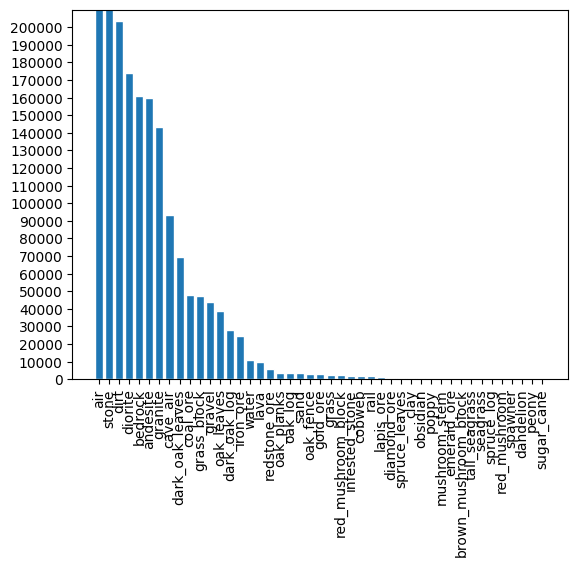

In [35]:
import matplotlib.pyplot as plt 
import numpy as np
# make data:
x = df["Tag"].value_counts().axes[0]
y = df["Tag"].value_counts()
print(y)
# plot
fig, ax = plt.subplots()

ax.bar(x, y, width=0.8, edgecolor="white")

ax.set(xticks=np.arange(0, len(x)),
       ylim=(0, 210000), yticks=np.arange(0, 210000,10000))

plt.xticks(rotation=90)
plt.show()

Se puede observar que la mayor cantidad de bloques en el mapa son aire y piedra, y sus cantidades son mucho mayores que los demás bloques.

## Distribución de los bloques de aire en el mapa

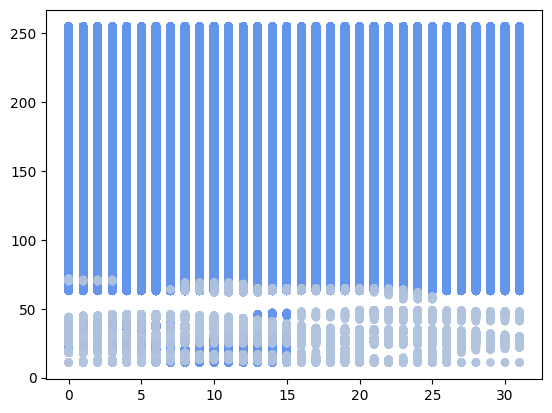

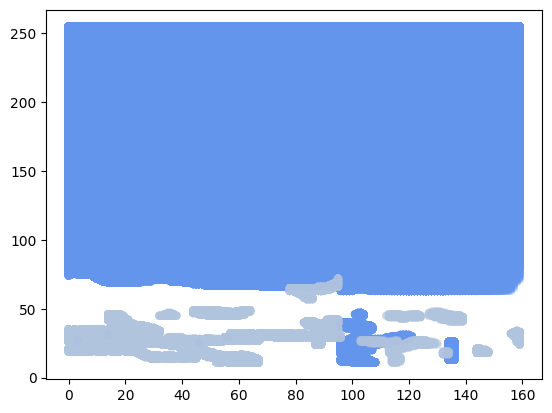

In [55]:
import matplotlib.pyplot as plt 
#Air block scatter plot
fig, ax = plt.subplots()
for lab in ["air", "cave_air"]:
    block = df[df.Tag == lab]
    x = block.X + block.CX*16 # coordenada absoluta
    y = block.Y 
    if lab == "air":
        color = "cornflowerblue"
    else:
        color = "lightsteelblue"
    ax.scatter(x, y, c=color, label=lab,
               alpha=0.3, edgecolors='none')
plt.show()

fig, ax = plt.subplots()
for lab in ["air", "cave_air"]:
    block = df[df.Tag == lab]
    z = block.Z + block.CZ*16 # coordenada absoluta
    y = block.Y 
    if lab == "air":
        color = "cornflowerblue"
    else:
        color = "lightsteelblue"
    ax.scatter(z, y, c=color, label=lab,
               alpha=0.3, edgecolors='none')
plt.show()


En estos gráficos podemos observar la distribución de los bloques de aire en azul y aire de cueva en color mas grisáceo. Se ve que a partir del la altura $Y = 70$ hay una gran cantidad de bloques de aire, pero también existe una pequeña porción de bloques de aire que se ubican justo en la grieta que se puede observar bajo tierra. Las demás cuevas contiene bloques de aire de cueva. 

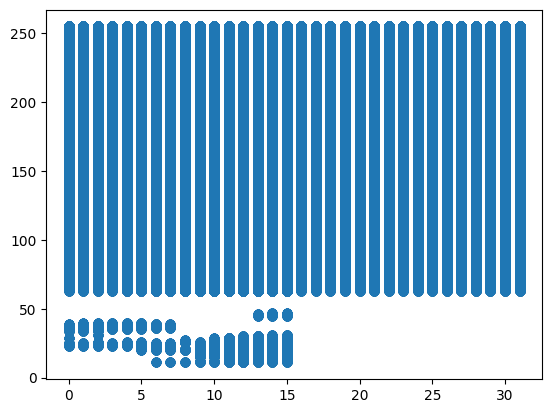

In [25]:
# plot x y
fig, ax = plt.subplots()
ax.scatter(xs, ys, vmin=0, vmax=100)
plt.show()

En este gráfico se observan los bloques de aire desde la perspectiva x,y. Nuevamente se puede observar que hay bloques de aire por debajo de y = 70 correspondientes a los que hay dentro de las cuevas.

## Distribución de la lava y el agua en el mapa

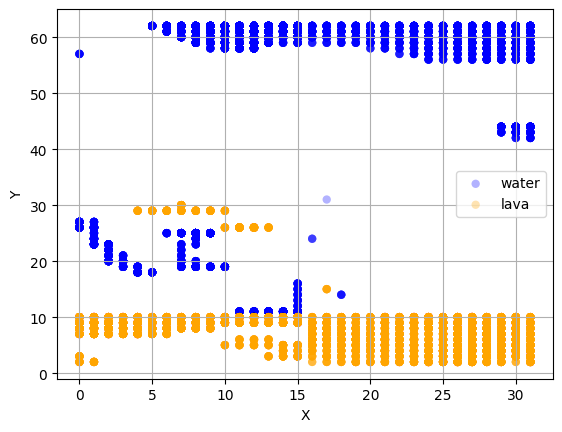

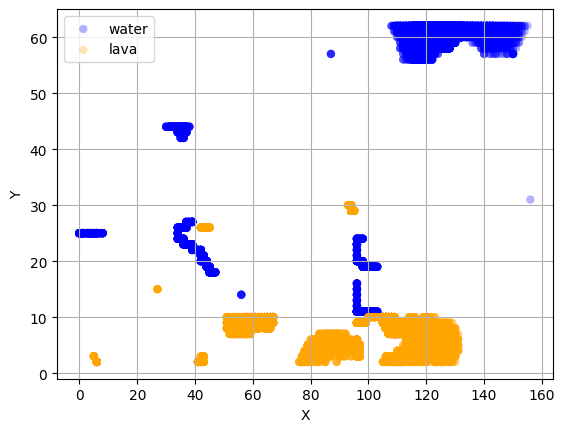

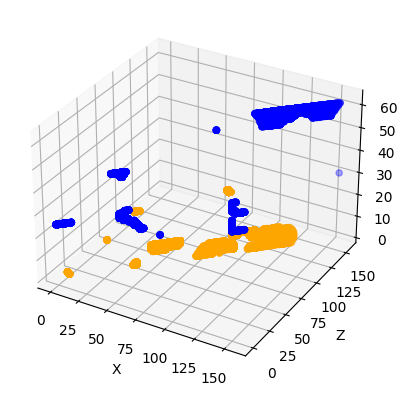

In [23]:
import numpy as np
import matplotlib.pyplot as plt
#lava and water scatter plot x and y
fig, ax = plt.subplots()
block = df
for lab in ["water", "lava"]:
    block = df[df.Tag == lab]
    x = block.X + block.CX*16 # coordenada absoluta
    y = block.Y 
    if lab == "water":
        color = "blue"
    else:
        color = "orange"
    ax.scatter(x, y, c=color, label=lab,
               alpha=0.3, edgecolors='none')
ax.legend()
ax.grid(True)
plt.xlabel("X")
plt.ylabel("Y")
plt.show()
#lava and water scatter plot z and y
fig, ax = plt.subplots()
block = df
for lab in ["water", "lava"]:
    block = df[df.Tag == lab]
    z = block.Z + block.CZ*16 # coordenada absoluta
    y = block.Y 
    if lab == "water":
        color = "blue"
    else:
        color = "orange"
    ax.scatter(z, y, c=color, label=lab,
               alpha=0.3, edgecolors='none')
ax.legend()
ax.grid(True)
plt.xlabel("X")
plt.ylabel("Y")
plt.show()
#lava and water scatter plot 3d
import matplotlib.pyplot as plt

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

for lab in ["water", "lava"]:
    block = df[df.Tag == lab]
    x = block.Z + block.CZ*16 # coordenada absoluta
    y = block.Y 
    z = block.Z + block.CZ*16 # coordenada absoluta
    if lab == "water":
        color = "blue"
    else:
        color = "orange"
    ax.scatter(x,z,y, c=color)
plt.xlabel("X")
plt.ylabel("Z")    
plt.show()

Se puede observar que hay más lava mientras mas profundo en el mapa se esta, ademas hay agua en la superficie del mapa (en el río) y hay agua en algunas cuevas bajo tierra. 

## Distribución de tierra y arboles en el mapa

c:\Program Files\Python310\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


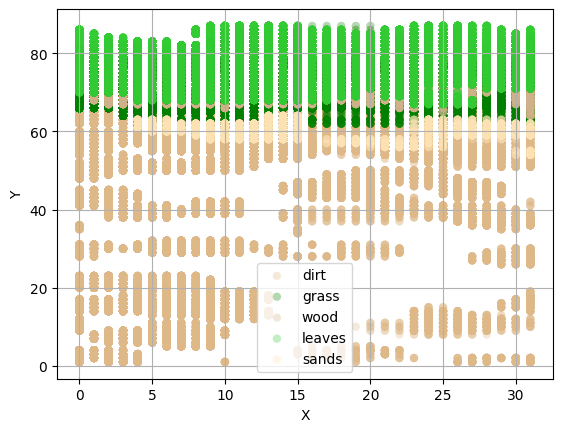

c:\Program Files\Python310\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


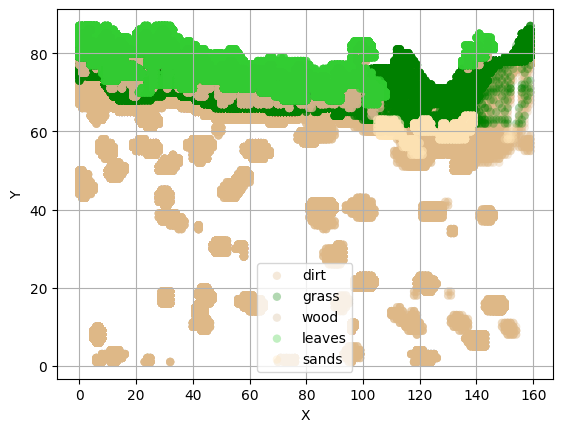

c:\Program Files\Python310\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


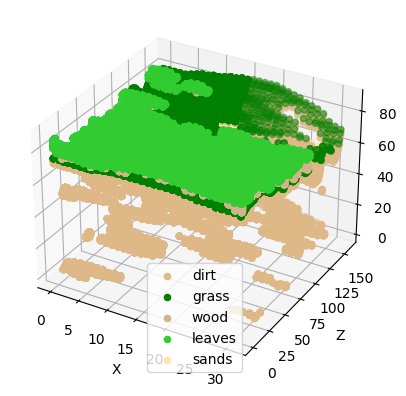

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#lava and water scatter plot x and y
#2D Plot
for dim in range(0,3):
    if(dim ==2):
        fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
    else:
        fig, ax = plt.subplots()
    for lab in [['dirt'],['grass_block'],['oak_log','dark_oak_log','spruce_log'],['oak_leaves','dark_oak_leaves','spruce_leaves'],['sand','clay']]:
        block = df[df.Tag == lab[0]].copy()
        for i in range(1,len(lab)):
            block = block.merge(df[df.Tag == lab[i]],"outer")
        z = block.Z + block.CZ*16 # coordenada absoluta
        x = block.X + block.CX*16 # coordenada absoluta
        y = block.Y
        
        if lab[0] == "dirt":
            color = "burlywood"
            labName = "dirt"
        elif lab[0] == "grass_block":
            color = "green"
            labName = "grass"
        elif lab[0] == "oak_log":
            color = "tan"
            labName = "wood"
        elif lab[0] == "oak_leaves":
            color = "limegreen"
            labName = "leaves"
        elif lab[0] == "sand":
            color = "moccasin"
            labName = "sands"
        else:
            color = "white"
            labName = "None"
        if(dim == 0):
            ax.scatter(x, y, c=color, label=labName,alpha=0.3, edgecolors='none')
            plt.xlabel("X")
            plt.ylabel("Y")
        elif(dim == 1):
            ax.scatter(z, y, c=color, label=labName,alpha=0.3, edgecolors='none')
            plt.xlabel("X")
            plt.ylabel("Y")
        elif(dim == 2):
            ax.scatter(x,z,y,label=labName, c=color)
            plt.xlabel("X")
            plt.ylabel("Z")
    ax.grid(True)
    ax.legend()
    plt.show()

Observaciones respecto a los 3 graficos.

## Detección de Outliers o datos apartados

## Preprocesamiento
### Creación de atributos
Bien, sbaemos que para la deteccion de patrones y generación de reglas de asociacion existe el algoritmo Apriori. Pero, en este caso ¿Sobre que deseo realizar inferencia de patrones? Es tambien importante distinguir entre utilizar un algoritmo para realizar clustering y otro para inferencia de reglas de asociación.
Si aplicaramos clustering lo que lograriamos es agrupar los bloques en sus respectivas clases que en este caso son explicitas y se trata del su tipo de bloque correspondiente. Por otro lado, en lo que se quiere hacer foco es en la deteccion de patrones en las relaciones espaciales que existen entre los bloques en el mapa. Es decir realizar inferencia sobre los atributos que describen las relaciones implicitas que existen entre todos los bloques en el mapa.

Entendiendo entonces que se quiere buscar patrones en las relaciones que hay entre los bloques. Como se deberia proceder?
El conjunto de datos que se extraen del juego nos describe unicamente el tipo de bloque y su posicion relativa a el chunk y su posicion relatival al origen de coordenadas recatangulares. Practicamente no hay ninguna relacion explicita en los datos.

entendiendo esto. El siguiente problema a resolver consiste en generar atributos apartir de los datos obtenidos que describan relaciones entre los bloques.
Hay que tener 3 cuestiones en cuenta para esto:
- Generar atributos posiblemente nos limite a obtener patrones en funcion de los atributos que describan la relacion. Minetras más atributos, mas posibles relaciones puedan descubrise.
- Como abarcar el problema de cantidad de objetos. Si suponemos que cada bloque tiene alguna relacion con cada otro bloque, el problema resulta intratable con n^2 relaciones.¿Nos ayuda el concepto de neihgbour? Cuantos vecinos sería optimo colocar?
-  El concept lattice buscaba de cierta manera concervar las relaciones implicitas? o era otra cosa
- Una vez entendido lo anterior. Hay que eliminar los outlaiers para reducir el dataset

Pasos:
1. Implementar Apriori
2. Detección de outliers con Metodo Scatters
3. Correr Apriori en los datos
4. Ingeniería de Features
5. Correr Apriori
6. Cloud model con features
7. Correr Apriori
8. Point process ("Se aplica al problema, pero como es la salida?")
9. Realizar comparación de resultados
10. Elaborar el informe final con los resultados obtenidos

3 aplicaciones:
Apriori con datos sin modificiar 
Apriori con eliminación de outliers
Apriori con ingenieria de features
Apriori con cloud model
Point process?

In [2]:
preprocess.basic()

NameError: name 'preprocess' is not defined

## Datos apartados luego de la Creación de atributos
### Variogram Scatterplots
### Moran scatterplots

In [ ]:
#Preprocess

preprocess.cloudModel()
preprocess.comceptLattice()

#Run Apriori Algorithm

#Generate metrics and plots from Result
    #Ploting and Metrics


## Association Rules Theory
### Definitions
- *Association*: $Z \subseteq I$, if the frequency of ocurrences of $Z$ deviates from our expectation given the frequencies of individual $X \in Z$.
- *$X \rightarrow Y$* an *assocaition rule* with antecedent X and consequent Y if $ Z = X \cup Y \subseteq I$ and $X \cap Y = 0$ holds.
- The support of the rule is defined as $supp(X→Y):=supp(X\cup Y)$, where the support of an arbitrary itemset $S$ is defined as the probability $P(S)$ of observing S in a randomly selected record of D:
$supp(S) = \frac{|{T∈D|S⊆T}|}{|D|}$

# Bibliografía y Papers relacionados #

## Association Rules mining ##

+ [Métricas para reglas de association](https://towardsdatascience.com/association-rules-2-aa9a77241654)
+ [Priori en R](https://www.geeksforgeeks.org/association-rule-mining-in-r-programming/#:~:text=Association%20Rule%20Mining%20in%20R%20Language%20is%20an%20Unsupervised%20Non,in%20a%20transaction%20or%20relation.)
+ [Lista de algoritmos para minería de reglas de asociación](https://personal.ntu.edu.sg/assourav/Unpublished/UP-ARMSurvey.pdf)

## Spacial Association Rules mining ##

+ [Enhancing spatial association rule mining in geographic databases](https://www.lume.ufrgs.br/handle/10183/7841)
+ [POWERPOINT Spatial Association Rules](https://www.ismll.uni-hildesheim.de/lehre/spatial-09w/script/association_web.pdf)
+ [Papers del Power anterior](http://www.spatial.cs.umn.edu/paper_list.html)
+ [SPADA system for spatial association rules mining on spatial databases](https://edz.bib.uni-mannheim.de/www-edz/pdf/eurostat/02/KS-CS-02-001-EN-N-EN.pdf#page=26)
+ [Discovering spatial interaction patterns of near repeat crime by spatial association rules mining](https://www.nature.com/articles/s41598-020-74248-w)
+ [Exploring spatial data](https://libraries.mit.edu/files/gis/exploring_spatial_patterns_iap2013.pdf)
## Procedural generation ##

+ [DISEÑO DE ALGORITMO DE GENERACIÓN PROCEDURAL ENFOCADO A VIDEOJUEGOS](https://repositorio.usm.cl/bitstream/handle/11673/49444/3560902038911UTFSM.pdf?sequence=1&isAllowed=y)

## Minecraft related content ##

+ [The World Generation of Minecraft](https://www.alanzucconi.com/2022/06/05/minecraft-world-generation/)
+ [JS chunk visualizer](https://pessimistress.github.io/minecraft/)
+ [I Wrote a 3D Chunk Visualizer for Minecraft](https://www.youtube.com/watch?v=fpGsOdxcU2M&ab_channel=ParametricCamp)
+ [An easy to use and fast Minecraft world viewer](https://unmined.net)
+ [enkiMI Minecraft 3D editor](https://www.reddit.com/r/VoxelGameDev/comments/8c4a67/a_better_way_to_extract_minecraft_data/)
+ [Minecraft Region file format](https://minecraft.fandom.com/wiki/Region_file_format)
+ [Minecraft Region file Wikipedia](https://wiki.vg/Region_Files)
+ [Formato NBT](https://minecraft.fandom.com/es/wiki/Formato_NBT)
+ [Anvil Parser](https://github.com/matcool/anvil-parser)